In [1]:
from transformers import BartTokenizer, BartModel
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import numpy as np
from datasets import load_dataset
import random
import torch
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from random import randint
from pattern.en import pluralize, singularize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


2024-02-02 00:50:20.360131: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 00:50:20.378929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 00:50:20.378950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 00:50:20.379408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 00:50:20.382612: I tensorflow/core/platform/cpu_feature_guar

True

In [2]:
sentence = "This is an example sentence showing off the verb extraction capabilities."
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)

verbs = [word for word, tag in tagged if tag.startswith('VB')]
adjectives = [word for word, tag in tagged if tag.startswith('JJ')]
nouns = [word for word, tag in tagged if tag.startswith('NN')]

def check_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    nouns = [word for word, tag in tagged if tag.startswith('NN')]
    verbs = [word for word, tag in tagged if tag.startswith('VB')]
    adjectives = [word for word, tag in tagged if tag.startswith('JJ')]

    if len(nouns) + len(verbs) +len(adjectives) == 0:
        return True
    else:
        return False



def drop_noun(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    nouns = [word for word, tag in tagged if tag.startswith('NN')]

    # If there are nouns, drop a random one
    if nouns:
        noun_to_drop = random.choice(nouns)
        tokens = [token for token in tokens if token != noun_to_drop]
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no nouns
        return sentence

def drop_verb(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    verbs = [word for word, tag in tagged if tag.startswith('VB')]

    # If there are verbs, drop a random one
    if verbs:
        verb_to_drop = random.choice(verbs)
        tokens = [token for token in tokens if token != verb_to_drop]
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no verbs
        return sentence

def drop_adjective(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, tag in tagged if tag.startswith('JJ')]

    # If there are adjectives, drop a random one
    if adjectives:
        adjective_to_drop = random.choice(adjectives)
        tokens = [token for token in tokens if token != adjective_to_drop]
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no adjectives
        return sentence

In [3]:
from transformers import pipeline
from transformers import pipeline, BartTokenizer

model_name = "facebook/bart-large-cnn"
summarizer = pipeline("summarization", model=model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

def get_summary(original_sentence):
    # Tokenize the input and truncate if it's too long
    tokens = tokenizer.encode(original_sentence, add_special_tokens=False)
    max_length_allowed = tokenizer.model_max_length
    if len(tokens) > max_length_allowed:
        # Truncate the tokens to the maximum length allowed
        tokens = tokens[:max_length_allowed]

    # Convert tokens back to text
    truncated_text = tokenizer.decode(tokens, skip_special_tokens=True)

    # Summarize the truncated text
    summary = summarizer(truncated_text, max_length=500, min_length=30, do_sample=False)
    return summary[0]['summary_text']


In [4]:
import sacrebleu

def calculate_bleu_score(candidate, reference):
    """
    Calculate the BLEU score for a candidate sentence given a reference sentence.

    Args:
    candidate (str): The summarized text (candidate translation).
    reference (str): The reference text (reference translation).

    Returns:
    float: The BLEU score.
    """
    bleu = sacrebleu.corpus_bleu([candidate], [[reference]])
    return bleu.score

candidate_summary = "The scientist presented her climate change research at a conference, calling for urgent action."
reference_summary = "At the conference, the scientist highlighted the need for immediate measures against climate change."

bleu_score = calculate_bleu_score(candidate_summary, reference_summary)
print(f"BLEU Score: {bleu_score}")


BLEU Score: 7.955891555490761


In [5]:
from transformers import BartTokenizer, BartModel
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import numpy as np
from datasets import load_dataset
import random
import torch

dataset = load_dataset("openai/summarize_from_feedback", 'axis')

action_list = [
    drop_noun,
    drop_verb,
    drop_adjective
]

action_list_name = [
  'drop_noun',
    'drop_verb',
    'drop_adjective'
]

sentence = "Your example sentence here."
index = 2
action_list[index](sentence)

'Your example sentence here.'

In [6]:
class BARTEmbedder:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        self.model = BartModel.from_pretrained('facebook/bart-large').to(self.device).half()  # Using FP16
        self.target_dim = 1024  # Target embedding dimension

    def get_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', max_length=1024, truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.encoder_last_hidden_state
        embeddings = torch.mean(embeddings, dim=1)

        # Adjust the embedding to have the target dimension
        embedding_dim = embeddings.shape[1]
        if embedding_dim > self.target_dim:
            embeddings = embeddings[:, :self.target_dim]
        elif embedding_dim < self.target_dim:
            padding = torch.zeros((embeddings.shape[0], self.target_dim - embedding_dim), device=self.device)
            embeddings = torch.cat([embeddings, padding], dim=1)

        return embeddings.cpu().numpy()


class NLPEnv(gym.Env):
    def __init__(self):
        super(NLPEnv, self).__init__()
        self.dataset = dataset
        self.current_word = None
        self.ground_truth = None
        self.embedder = BARTEmbedder()
        embedding_dim = 1024
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(embedding_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)
        self.count = 0
    
        action_list = [
            drop_noun,
            drop_verb,
            drop_adjective
        ]


    def reset(self):
        self.count = 0
        random_index = 0
        self.current_word = self.dataset['test']['info'][random_index]['article'][:3500]
        self.ground_truth = self.dataset['test']['summary'][random_index]['text'][:3500]
        return self.embedder.get_embedding(self.current_word)

    def step(self, action):
        
        check = check_sentence(self.current_word)

        prediction = action_list[action](self.current_word)
        prediction = ' '.join(prediction)
        summary = get_summary(prediction)
        bleu_score = calculate_bleu_score(prediction, summary)
        reward = bleu_score - self.count
        done = False
        self.current_word = prediction

        if check:
            done = True
        self.count +=1

        print(f'Reward: {reward} Action: {action_list_name[action]} Word length: {len(self.current_word)} Prediction length: {len(summary)}')
        if reward < 5.0:
            done = True
            steps.append(self.count) 
            print('EPISODE COMPLETE')    
               
        return self.embedder.get_embedding(prediction), reward, done, {'current_word': self.current_word}


In [7]:
env = DummyVecEnv([lambda: NLPEnv()])
dqn_model_bart_multi = DQN("MlpPolicy", env, verbose=1, exploration_final_eps=0.6, exploration_initial_eps=1.0)#DQN model

Using cuda device


/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [8]:
#uncomment to learn
# steps = []

# dqn_model_bart_multi.learn(1000)
# # dqn_model_bart_multi.save('dqn_model_bart_multi_steps')

In [9]:
dqn_model_bart_multi = DQN.load('RL models/dqn_model_bart_multi_steps')

In [16]:
episode_rewards = []
episode_actions = []
proxy_prob = []
steps = []
for episode in range(300):
    print(f"Episode: {episode}")
    done = False
    obs = env.reset()
    q_values = dqn_model_bart_multi.policy.q_net(torch.tensor(obs, dtype=torch.float32, device = dqn_model_bart_multi.device))
    action_probabilities = torch.nn.functional.softmax(q_values, dim=1)
    proxy_prob.append(action_probabilities)
    while not done:
        action, _ = dqn_model_bart_multi.predict(obs)
        obs, reward, done, info = env.step(action)
        print(f'Actions : {action}, Reward: {reward}')
        episode_rewards.append(reward)
        episode_actions.append(action)

Episode: 0


Token indices sequence length is longer than the specified maximum sequence length for this model (4213 > 1024). Running this sequence through the model will result in indexing errors


Reward: 7.501940106230893 Action: drop_noun Word length: 7059 Prediction length: 7059
Actions : [0], Reward: [7.5019403]
Reward: 0.6390273754828617 Action: drop_noun Word length: 10757 Prediction length: 10757
EPISODE COMPLETE
Actions : [0], Reward: [0.63902736]
Episode: 1
Reward: 8.773314320316349 Action: drop_noun Word length: 4911 Prediction length: 4911
Actions : [0], Reward: [8.773314]
['A', '1', '-', 'y', 'e', 'a', 'r', '-', 'o', 'l', 'd', 'g', 'i', 'r', 'l', 'w', 'h', 'o', 'w', 'a', 's', 's', 'h', 'o', 't', 'i', 't', 'h', 'e', 'h', 'e', 'a', 'd', 'i', 'a', 'd', 'r', 'i', 'v', 'e', '-', 'b', 'y', 's', 'h', 'o', 'o', 't', 'i', 'g', 'o', 'u', 't', 's', 'i', 'd', 'e', 'S', 'e', 'a', 't', 't', 'l', 'e', 'h', 'a', 's', 'd', 'i', 'e', 'd', '.', 'A', 's', 'p', 'o', 'k', 'e', 's', 'w', 'o', 'm', 'a', 'f', 'o', 'r', 'H', 'a', 'r', 'b', 'o', 'r', 'v', 'i', 'e', 'w', 'M', 'e', 'd', 'i', 'c', 'a', 'l', 'C', 'e', 't', 'e', 'r', 's', 'a', 'y', 's', 't', 'h', 'e', 'g', 'i', 'r', 'l', 'w', 'a', 

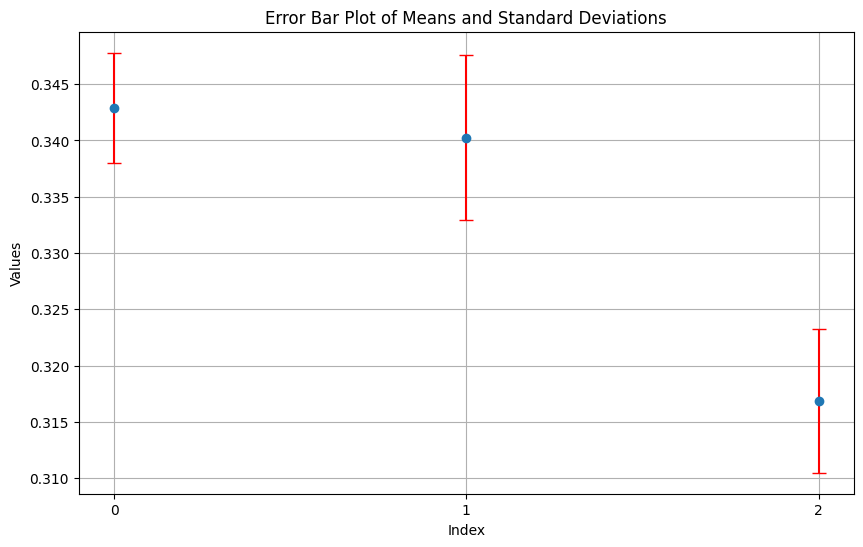

In [31]:
# Convert the list of tensors to a single tensor
data_tensor = torch.stack(proxy_prob)

# Calculate the mean and standard deviation for each index
means = torch.mean(data_tensor, dim=0)
std_devs = torch.std(data_tensor, dim=0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

means_np = means.cpu().detach().numpy()
std_devs_np = std_devs.cpu().detach().numpy()


# Data for plotting
indices = range(0, 3)

# Creating error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(indices, means_np[0], yerr=std_devs_np[0] * 10, fmt='o', ecolor='red', capsize=5)
plt.title('Error Bar Plot of Means and Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(indices)
plt.grid(True)
plt.show()

